In [27]:
!unzip fake_news.zip

Archive:  fake_news.zip
replace FakeNewsNet.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Import Library

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Import Dataset

In [30]:
df = pd.read_csv('FakeNewsNet.csv')
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


## Menghapus Tanda Baca Pada Teks

In [31]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

df["title"] = df["title"].apply(remove_punctuation)

## Menghapus konjungsi atau kata tambahan yang tidak perlu

In [32]:
NUM_WORDS = 1300

stop_words = set(stopwords.words("english"))

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="x", split=" ")
tokenizer.fit_on_texts(df["title"].astype(str))

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

df["title"] = df["title"].apply(preprocess_text)


## Data Splitting

In [33]:
X = df["title"]
y = df["real"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tokenizing & Sequencing

In [34]:
MAXLEN = 100

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(
    X_train_sequences,
    maxlen=MAXLEN,
    padding="post",
    truncating="post"
)

X_test_padded = pad_sequences(
    X_test_sequences,
    maxlen=MAXLEN,
    padding="post",
    truncating="post"
)

## Modelling

In [35]:
all_words = set()
for i in pd.concat([X_train, X_test]).astype(str).tolist():
    for j in i.split():
        all_words.add(j)

NUM_WORDS = len(all_words) + 1

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, output_dim=MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.GaussianDropout(0.1),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.build(input_shape=(None, MAXLEN))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 100)            │       2,491,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 100, 1024)           │       2,510,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 100, 512)            │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_dropout_2 (GaussianDropout) │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,381,437 (31.97 MB)

 Trainable params: 8,381,437 (31.97 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.01,
        clipvalue=0.5,
    ),
    metrics=["accuracy"]
)

## Membuat EarlyStopping Callback

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    verbose=1,
    restore_best_weights=True
)

## Training Model

In [39]:
history = model.fit(
    X_train_padded,
    y_train,
    epochs=30,
    validation_data=(X_test_padded, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 49s 75ms/step - accuracy: 0.7360 - loss: 0.6082 - val_accuracy: 0.7563 - val_loss: 0.5607
Epoch 2/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.7489 - loss: 0.5663 - val_accuracy: 0.7563 - val_loss: 0.5568
Epoch 3/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 79s 71ms/step - accuracy: 0.7472 - loss: 0.5666 - val_accuracy: 0.7563 - val_loss: 0.5563
Epoch 4/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.7558 - loss: 0.5565 - val_accuracy: 0.7563 - val_loss: 0.5555
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [40]:
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

y_pred_classes = y_pred_classes.flatten()

accuracy = np.mean(y_pred_classes == y_test)
print("Accuracy:", accuracy)

145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Accuracy: 0.75625


In [41]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, output_dict=True, zero_division=1)
df_report = pd.DataFrame(report).transpose()

def highlight(val):
    return 'background-color: black; color: white'

styled_df = df_report.style.map(highlight)

display(styled_df)

,precision,recall,f1-score,support
0,1.000000,0.000000,0.000000,1131.000000
1,0.756250,1.000000,0.861210,3509.000000
accuracy,0.756250,0.756250,0.756250,0.756250
macro avg,0.878125,0.500000,0.430605,4640.000000
weighted avg,0.815664,0.756250,0.651290,4640.000000


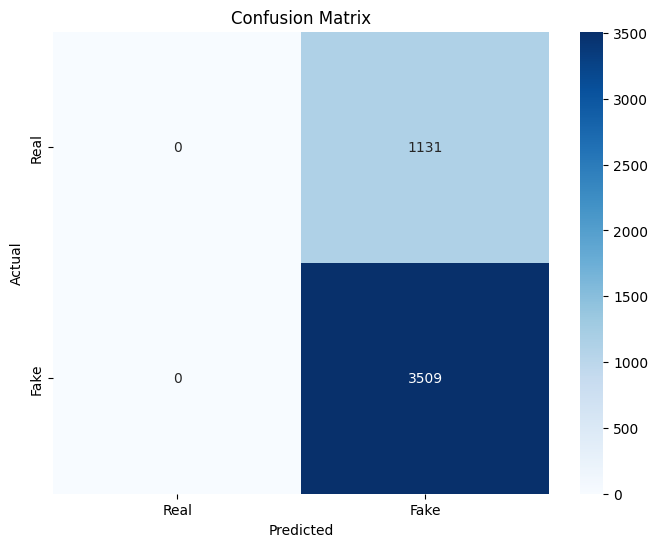

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


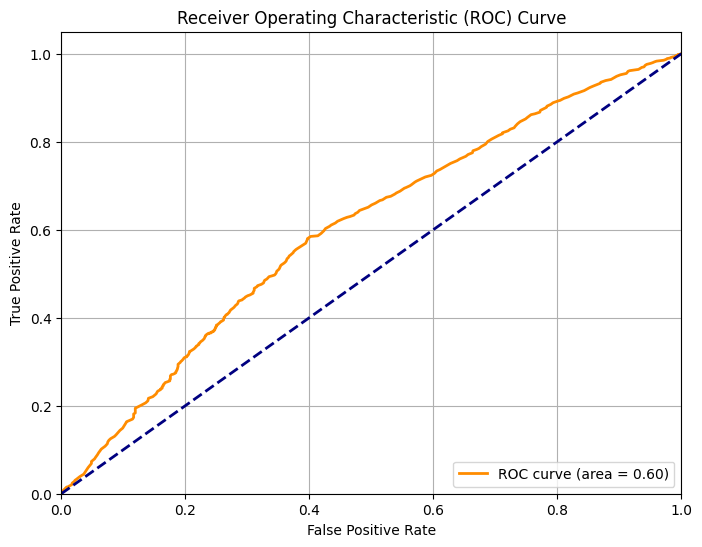

In [43]:
y_pred_proba = model.predict(X_test_padded)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

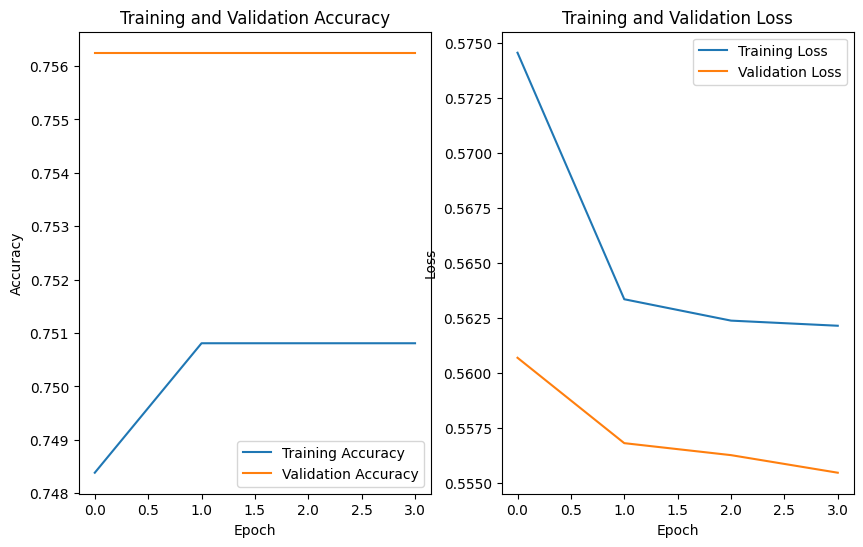

In [44]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()